# example data science pipeline

let's run through a couple steps to fit several models to the adult income dataset

## imports and constants

In [1]:
# this line configures matplotlib (the backbone of the pandas
# plotting functions) to render the graphs it makes in the 
# notebook
%matplotlib inline

# for these "import ... as ..", the alias terms (phrases after "as")
# are simply conventions. You will usually see stack overflow code
# referencing these aliases
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline
import seaborn as sns
import sklearn
import sklearn.datasets
import sklearn.ensemble
import sklearn.externals.joblib
import sklearn.feature_selection
import sklearn.linear_model
import sklearn.model_selection
import sklearn.neural_network
import sklearn.pipeline
import sklearn.preprocessing

# this step invokes seaborn one time to make the default plot
# configurations of matplotlib less heinous
sns.set()

# this command informs the plotly module that you are connected
# to the internet but wish to run in "offline" mode (that is,
# graph things like a normal plotting library instead of sending
# everything off to plotly HQ)
plotly.offline.init_notebook_mode(connected=True)

## loading data

let's go download a relatively large dataset that is available as part of the [UCI machine learning repository](http://archive.ics.uci.edu/ml/index.php). I've chosen the [Adult](http://archive.ics.uci.edu/ml/datasets/Adult) dataset 

### keeping things simple

we *could* use the requests library to download and parse the column names (available [here](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names)), but instead I've just hard-coded them below.

also, we *could* use the pre-segregated train and test data sets as our train and test, but that would involve some data munging and cleaning that is a bit of a mess, and also results in enough data points in our final plots that we'd have to change some annoying configuration variables. instead, let's pull only the smaller training dataset, and use the `scikit-learn` train / test split function to create a test dataset of our own.

In [2]:
columns = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'target'
]

df = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
    names=columns,
    delimiter=', ',
    index_col=False,
    engine='python'
)

let's print the first 5 records of that dataset `df`

In [3]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


ugh. those column names... those dashes... abominations.

let's clean that up. I can clean up one using the following

In [4]:
col = 'capital-gain'
col.replace('-', '_')

'capital_gain'

let's use a list comprehension to clean up the elements of `df.columns`

In [5]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'target'],
      dtype='object')

In [6]:
df.columns = [col.replace('-', '_') for col in df.columns]

and now, the first 5 records again, to see that the column names have changed:

In [7]:
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


and it'd be good to know the shape of this dataframes:

In [8]:
df.shape

(32561, 15)

## pre-processing

let's put together a sequence of pre-processing operations we wish to do to our test and train datatset. Since we're going to do it to both test and train, it'd be good to build up a function along the way (so we don't have to repeat every command twice).

### dropping some columns

let's skip some of the hard work and just know, ahead of time, that the column `fnlwgt` and `education_num` should be dropped. Why?

1. `fnlwgt` is a weighting for demographic sampling, and is an estimate of how many people fall into the given category. we're not going to use this weighting, so let's get rid of it.
2. `education_num` is a numerical representation of the values in the `education` column. You could argue that you should keep this numeric column and drop the `education` column, or convert `education` into a dummy column and drop `education_num`. we'll do the latter.

In [9]:
df = df.drop(['fnlwgt', 'education_num'], axis=1)

### converting categorical factors to numerical dummy factors

let's convert the categorical columns in this dataset to dummy variables, and then extract the numerical values into an `X` and `Y` dataset

first, let's look at the number of values for each category:

In [10]:
for col in df.columns:
    print('{}: {}'.format(col, df[col].nunique()))

age: 73
workclass: 9
education: 16
marital_status: 7
occupation: 15
relationship: 6
race: 5
sex: 2
capital_gain: 119
capital_loss: 92
hours_per_week: 94
native_country: 42
target: 2


investigation of the number of valid elements (as well as a measure of common sense) leads to the following list of categorical values which should be converted into dummy variables:

In [11]:
dummycols = [
    'workclass',
    'education',
    'marital_status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native_country'
]

the `target` column, though categorical, is left out because we're about to use the above list to convert our categorical *predictors* into dummy variables.

given a single category variable, we could convert one of the textual category factors above into a set of dummy variable factors as follows:

In [12]:
col = 'sex'
dummies = pd.get_dummies(
    df[col],
    prefix=col,
    dummy_na=True
)
dummies.head()

,sex_Female,sex_Male,sex_nan
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,1,0,0


furthermore, given the dataframe of dummy variables `dummies` we created we could join those rows into the original `df` or `dftest` dataframes using the `join` method:

```python
anycatnull = df[col].isnull().any()
df = df.join(dummies, prefix='sex', dummy_na=anycatnull)
```

use the above methods to join dummy variables for each of our `dummycols` into both our train and test dataframes

In [13]:
for dummycol in dummycols:
    df = df.join(
        pd.get_dummies(
            df[dummycol],
            prefix=dummycol,
            dummy_na=df[dummycol].isnull().any()
        )
    )

In [14]:
df.head()

,age,workclass,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,...,0,0,0,0,0,0,0,1,0,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,...,0,0,0,0,0,0,0,0,0,0


### fixing column names again

some of those dummy variable names are pretty gnarly (dashes and capital letters abound!), so let's fix the column names one more time. we could fix a single column name via:

In [15]:
col = 'native_country_Puerto-Rico'
col.lower().replace('-', '_')

'native_country_puerto_rico'

In [16]:
df.columns = [col.lower().replace('-', '_') for col in df.columns]

In [17]:
df.head()

,age,workclass,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,...,native_country_portugal,native_country_puerto_rico,native_country_scotland,native_country_south,native_country_taiwan,native_country_thailand,native_country_trinadad&tobago,native_country_united_states,native_country_vietnam,native_country_yugoslavia
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,...,0,0,0,0,0,0,0,1,0,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,...,0,0,0,0,0,0,0,0,0,0


### fixing the target categorical variable

currently, our target looks like

In [18]:
df.target.value_counts()

<=50K    24720
>50K      7841
Name: target, dtype: int64

let's replace those string values with numerical targets.

there are two ways we could do this. first, we could convert this factor into a *category*, and then use the integer values (called *codes*) that are assigned to the two types:

In [19]:
df.target.astype('category').cat.codes.head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    1
9    1
dtype: int8

the second way we could do this is with a simple boolean expression, converted to an integer:

In [20]:
(df.target == '>50K').head(10)

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7     True
8     True
9     True
Name: target, dtype: bool

In [21]:
(df.target == '>50K').astype(int).head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    1
9    1
Name: target, dtype: int64

either would work. I'll go with the category version for this step

in `pandas`, whenever you *create* or *re-assign* features, you should use the `.loc` or `.iloc` indexers (not the `.` or `[...]` notations, as might feel more natural):

```python
# one new or re-assigned feature
df.loc[:, 'colname'] = newvalues

# several new or re-assigned features
df.loc[:, ['col1', 'col2', ...]] = newvalues
```

in the above, the items inside the `[...]` are the row index slice statement (a "`:`" character means "all rows"), and the item after the comma is the column index slice statement (a column name as a string, or a list of multiple columns).

the item on the left will have a certain number of rows and a certain number of columns; the right hand side must be of the same size.

we'll use the `loc` indexer here (we are *replacing* `target` values)

In [22]:
df.loc[:, 'target'] = df.target.astype('category').cat.codes

### dropping non-numeric features

let's get rid of the text features (most of which we just converted into dummy variables). this is straight-forward using the *hidden* dataframe class member function (items with one leading `_` are called "hidden" member functions) `_get_numeric_data`, which restricts a dataframe to only those columns with a *numeric* `dtype` (a `numpy` concept representing the type of data stored in a column).

In [23]:
df = df._get_numeric_data()
df.head()

,age,capital_gain,capital_loss,hours_per_week,target,workclass_?,workclass_federal_gov,workclass_local_gov,workclass_never_worked,workclass_private,...,native_country_portugal,native_country_puerto_rico,native_country_scotland,native_country_south,native_country_taiwan,native_country_thailand,native_country_trinadad&tobago,native_country_united_states,native_country_vietnam,native_country_yugoslavia
0,39,2174,0,40,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,0,0,13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,0,0,40,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,53,0,0,40,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,28,0,0,40,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### standardizing

#### `log`-transform of monetary features

we have some monetary information, so it'd be good to `log` normalize those. Let's also normalize all numerical features!

In [24]:
moneycols = [
    'capital_gain',
    'capital_loss'
]

to show these distributions have long tails and problematic distributions:

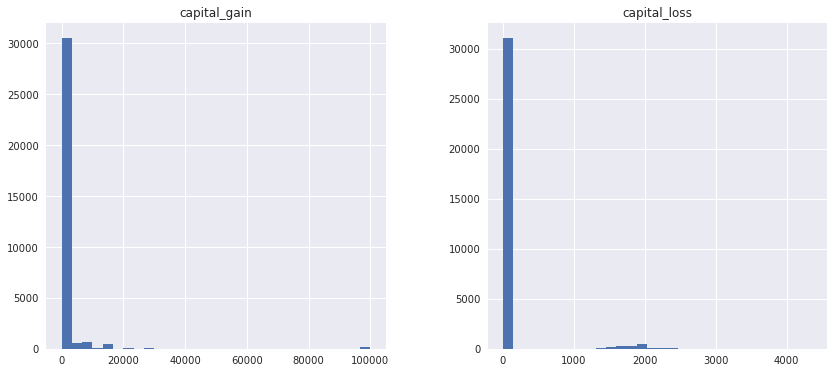

In [25]:
df[moneycols].hist(figsize=(14, 6), bins=30);

we can easily calculate the `log(1 + x)` value for those columns:

In [26]:
log1p = np.log1p(df[moneycols])
log1p.head()

,capital_gain,capital_loss
0,7.684784,0.0
1,0.000000,0.0
2,0.000000,0.0
3,0.000000,0.0
4,0.000000,0.0


what about the distributions under this transform?

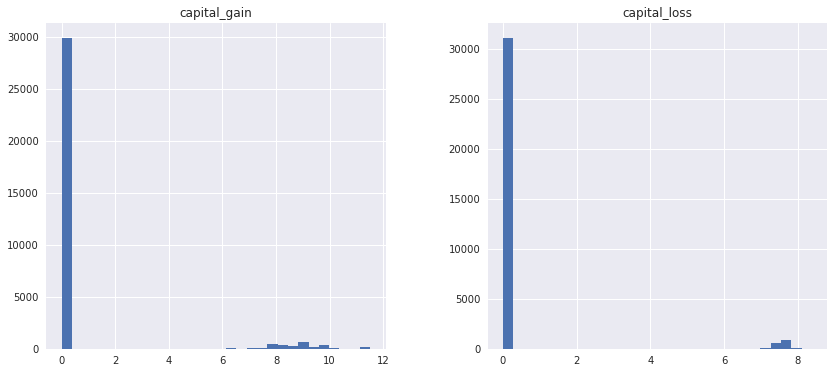

In [27]:
log1p.hist(figsize=(14, 6), bins=30);

let's use the `loc` indexer again, this time to *replace* the values of our `moneycols` with these `log`-transformed features.

in this case, we want to replace several columns, so we will write

```python
df.loc[:, listOfColumnNames] = newValuesForThoseColumns
```

In [28]:
df.loc[:, moneycols] = np.log1p(df[moneycols])

#### standardizing numerical features

let's go ahead and do the simplest thing -- standardizing *every* non-target variable. this is a little meaningless for dummy variables, but hey -- it's just an excercise, right?

In [29]:
nottarget = [col for col in df.columns if col != 'target']

we can scale items in a dataframe using the `sklearn.preprocessing.scale` function (note: this returns a `numpy` array without column names)

In [30]:
sklearn.preprocessing.scale(df[nottarget])

array([[ 0.03067056,  2.83136958, -0.22107451, ...,  0.34095391,
        -0.04540836, -0.02217266],
       [ 0.83710898, -0.29927115, -0.22107451, ...,  0.34095391,
        -0.04540836, -0.02217266],
       [-0.04264203, -0.29927115, -0.22107451, ...,  0.34095391,
        -0.04540836, -0.02217266],
       ..., 
       [ 1.42360965, -0.29927115, -0.22107451, ...,  0.34095391,
        -0.04540836, -0.02217266],
       [-1.21564337, -0.29927115, -0.22107451, ...,  0.34095391,
        -0.04540836, -0.02217266],
       [ 0.98373415,  3.61871092, -0.22107451, ...,  0.34095391,
        -0.04540836, -0.02217266]])

use the column list `nottarget` we just created, the `.loc` dataframe member function, and the `sklearn.preprocessing.scale` function to replace all non-target numeric values with their scaled values

In [31]:
df.loc[:, nottarget] = sklearn.preprocessing.scale(df[nottarget])

In [32]:
df.head()

,age,capital_gain,capital_loss,hours_per_week,target,workclass_?,workclass_federal_gov,workclass_local_gov,workclass_never_worked,workclass_private,...,native_country_portugal,native_country_puerto_rico,native_country_scotland,native_country_south,native_country_taiwan,native_country_thailand,native_country_trinadad&tobago,native_country_united_states,native_country_vietnam,native_country_yugoslavia
0,0.030671,2.831370,-0.221075,-0.035429,0,-0.24445,-0.174295,-0.262097,-0.014664,-1.516792,...,-0.033729,-0.059274,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,0.340954,-0.045408,-0.022173
1,0.837109,-0.299271,-0.221075,-2.222153,0,-0.24445,-0.174295,-0.262097,-0.014664,-1.516792,...,-0.033729,-0.059274,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,0.340954,-0.045408,-0.022173
2,-0.042642,-0.299271,-0.221075,-0.035429,0,-0.24445,-0.174295,-0.262097,-0.014664,0.659286,...,-0.033729,-0.059274,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,0.340954,-0.045408,-0.022173
3,1.057047,-0.299271,-0.221075,-0.035429,0,-0.24445,-0.174295,-0.262097,-0.014664,0.659286,...,-0.033729,-0.059274,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,0.340954,-0.045408,-0.022173
4,-0.775768,-0.299271,-0.221075,-0.035429,0,-0.24445,-0.174295,-0.262097,-0.014664,0.659286,...,-0.033729,-0.059274,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,-2.932948,-0.045408,-0.022173


## train and test split

in order to have some completely unseen data for final model validation, it's a good idea to hold out about 20 percent of your data. We can use the `sklearn.model_selection.train_test_split` function to split a single dataframe of labeled cases into two sets (train and test) of predictors and targets (`X` and `Y`), while keeping the prevalance of our target variable fixed between our training and testing `Y`.

In [33]:
sklearn.model_selection.train_test_split?

In [34]:
dftrain, dftest = sklearn.model_selection.train_test_split(
    df,
    test_size=0.2,
    random_state=1337,
    stratify=df.target
)

In [35]:
df.shape

(32561, 107)

In [36]:
dftrain.shape

(26048, 107)

In [37]:
dftest.shape

(6513, 107)

check the prevalence of the target (`target`) in each dataset is approximately equivalent

*hint: there are several ways you could calculate this, but you should look to the `value_counts` function*

In [38]:
dftrain.target.value_counts(normalize=True)

0    0.759175
1    0.240825
Name: target, dtype: float64

In [39]:
dftest.target.value_counts(normalize=True)

0    0.759251
1    0.240749
Name: target, dtype: float64

### `x` and `y`, at last

let's split our dataframes into `x` and `y` values for easier use in the `sklearn` world

In [40]:
xtrain = dftrain[nottarget].values
ytrain = dftrain['target'].values
xtest = dftest[nottarget].values
ytest = dftest['target'].values

## fitting a data science pipeline

the hard part is over! let's use `scikit-learn` to create a pipeline that combines feature selection and a modelling approach, and then evaluate the results of our model against the test dataset

### feature selection

let's try recursive feature elimination with random forests

In [41]:
# RFE with random forests
rf = sklearn.ensemble.RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=1337
)
rfe = sklearn.feature_selection.RFE(
    estimator=rf
)

### modeler

let's try a random forest, a logistic regression, and a neural net

In [42]:
mrf = sklearn.ensemble.RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=1337,
)

### pipelines

we could call the above items sequentially:

```python
xfs = rfe.fit_transform(xtrain, ytrain)
mrf.fit(xtrain, ytrain)
```

and that'd be fine. however, `scikit-learn` has a concept of *pipelines*, sequences of events that all expose these `fit`, `transform`, and `fit_transform` methods. it allows you to chain these items together in a sort of linux-esque sequence of piped commands (hence, pipeline).

let's create a pipeline.

In [43]:
pipeline = sklearn.pipeline.Pipeline(
    steps=[
        # a sequence of name, transformer objects
        ('rfe', rfe),
        ('random_forest', mrf)
    ]
)

fitting our model then is a simple call of the pipeline's `fit` method:

In [44]:
pipeline.fit(xtrain, ytrain)

Pipeline(memory=None,
     steps=[('rfe', RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
        ..._jobs=-1,
            oob_score=False, random_state=1337, verbose=0,
            warm_start=False))])

## plotting results

### feature importance

our pipeline has a feature selection element we can access via the `named_steps` member variable.

that fitted feature selection object has a few variables of interest:

1. `support`, accessed via `get_support()`: a boolean indicating whether or not a feature should be kep
2. `importance`: the average feature importance of a given feature across all the trees in our random forest 

In [45]:
fs = pipeline.named_steps['rfe']

In [46]:
fs.get_support()

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True, False,  True,  True, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False,  True, False,  True, False, False,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False], dtype=bool)

In [47]:
fs.estimator_.feature_importances_

array([ 0.23165484,  0.11448606,  0.03530543,  0.1155262 ,  0.00202263,
        0.00624543,  0.00754565,  0.01290963,  0.00692945,  0.0098643 ,
        0.00543983,  0.00276507,  0.00348776,  0.00386989,  0.00243531,
        0.00522452,  0.0061832 ,  0.02385624,  0.00690595,  0.01386863,
        0.01468562,  0.00702168,  0.01059766,  0.00688634,  0.07934161,
        0.02438746,  0.00196181,  0.00661982,  0.00740647,  0.02606153,
        0.00487561,  0.00351428,  0.00440368,  0.00809461,  0.02390165,
        0.00343352,  0.00783881,  0.00603502,  0.00510095,  0.03918638,
        0.00991857,  0.00814256,  0.0048733 ,  0.01079461,  0.00188954,
        0.00409284,  0.00610825,  0.00858662,  0.01101371,  0.00979615,
        0.00349146,  0.00251251,  0.01089936])

In [48]:
dfsupport = pd.DataFrame({
    'feature': nottarget,
    'support': fs.get_support()
})
dfsupport.head()

,feature,support
0,age,True
1,capital_gain,True
2,capital_loss,True
3,hours_per_week,True
4,workclass_?,True


In [49]:
# we only have feature importance for records where `support` is true
dfsupport.loc[
    dfsupport.support, 'importance'
] = fs.estimator_.feature_importances_
dfsupport.head()

,feature,support,importance
0,age,True,0.231655
1,capital_gain,True,0.114486
2,capital_loss,True,0.035305
3,hours_per_week,True,0.115526
4,workclass_?,True,0.002023


In [50]:
dfsupport = dfsupport.sort_values(by='importance', ascending=False)
dfsupport.head()

,feature,support,importance
0,age,True,0.231655
3,hours_per_week,True,0.115526
1,capital_gain,True,0.114486
31,marital_status_married_civ_spouse,True,0.079342
51,relationship_husband,True,0.039186


now, let's use `plotly`'s `Bar` element to create a **horizontal** bar chart. I'll fill in the majority of the items here, but you will need to figure out how to construct the actual bar chart data element.

this might be helpful: https://plot.ly/python/horizontal-bar-charts/

In [51]:
# drop the features which weren't chosen, and invert the sort
# order (plotly adds bars in this "top to bottom" way for
# horizontal bar charts)
nonzero = dfsupport[dfsupport.support].sort_values(by='importance')

In [52]:
data = [
    go.Bar(
        x=nonzero.importance,
        y=nonzero.feature,
        orientation='h',
    )
]

layout = go.Layout(
    # tall enough to include every feature we selected
    height=1200,
    # enough space to display the full feature name
    margin=go.Margin(l=250),
)

fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)

### prediction results

we can also easily make predictions with the fit pipeline object -- this will take raw input data, apply feature selection, and score the records:

In [53]:
ypred = pipeline.predict_proba(xtest)
ypred

array([[ 0.98,  0.02],
       [ 0.93,  0.07],
       [ 0.8 ,  0.2 ],
       ..., 
       [ 0.85,  0.15],
       [ 1.  ,  0.  ],
       [ 0.96,  0.04]])

the two columns in `ypred` are the predicted probability of the classes 0 and 1 for the target:

In [54]:
pipeline.classes_

array([0, 1], dtype=int8)

thus the probability of having a target value of 1 (equivalently: having a salary over $50K) is the second column

let's combine the predicted probabilities for our test set with the known labeled ground truth:

In [55]:
dfpred = pd.DataFrame({
    'ytest': ytest,
    'ypred': ypred[:, 1]
})
dfpred.head()

,ypred,ytest
0,0.02,0
1,0.07,0
2,0.20,1
3,0.01,0
4,0.00,0


let's use plotly to plot the cumulative captured response on the held out test data from the original dataframe. to do this, we will need to pick out the now-trained pipeline corresponding to our best run:

In [56]:
dfpred = dfpred.sort_values(by='ypred', ascending=False)
ntargets = dfpred.ytest.sum()
dfpred.loc[:, 'pct_captured'] = dfpred.ytest.cumsum() / ntargets

xarr = np.array(range(dfpred.shape[0]))
yperf = np.ones(xarr.shape)
yperf[:ntargets] = np.linspace(0, 1, ntargets)

In [57]:
data = [
    # our capture rate
    go.Scatter(
        x=xarr,
        y=dfpred.pct_captured,
        mode='lines',
        line={'width': 2},
        name='our prediction'
    ),
    # random choice
    go.Scatter(
        x=xarr,
        y=xarr / xarr.max(),
        mode='lines',
        line={
            'dash': 'dash',
            'color': 'black',
            'width': 1,
        },
        name='random'
    ),
    # perfect
    go.Scatter(
        x=xarr,
        y=yperf,
        mode='lines',
        line={
            'dash': 'dots',
            'color': 'black',
            'width': 1,
        },
        name='perfect'
    )
]

In [58]:
# create a layout with axes labels and title
layout = go.Layout(
    title='cumulative captured response',
    xaxis={'title': 'number of records recommend and investigated'},
    yaxis={'title': 'fraction of all true cases obtained'}
)

In [59]:
# create a figure to join the above
fig = go.Figure(
    data=data,
    layout=layout
)


plotly.offline.iplot(fig)

that is *pretty good*.

maybe *too pretty good*...

# you're done!

You can feel free to submit the homework if you've gotten to this point. However, what follows is a bit of an advanced digression into training multiple models, selecting the best one based on cross-validation, and evaluating that (hopefully better) model on the test data set

# **advanced**: cross-validation of multiple pipelines for model selection

we chose an arbitrary feature selection method and modelling approach above and had pretty good results from it -- lucky!

in practice, it would be better to try several different feature selection and modelling methods, and to try and find some test-agnostic way of selecting the best among them. a common approach is to create many different pipelines and for each pipeline evaluate a given metric under cross validation. The model with the best cross-validated metric score is then selected, and the final evaluation is then performed against the held out (test) data

### cross validation

we will need to do some cross validation for

1. grid searches for parameters, and
2. feature or model selection by metric scores on cross-validated samples

to accomplish this, we'll use the `sklearn.model_selection.StratifiedShuffleSplit`, an implementation of a fixed bootstrap cross validation selector.

In [60]:
cv = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=10,
    test_size=0.2,
    random_state=1337
)

### feature selectors

let's try recursive feature selection with random forests and lasso (done using the logistic regression cross validation model with an L1 penalty

In [61]:
# RFE with random forests
rf = sklearn.ensemble.RandomForestClassifier(n_jobs=-1, random_state=1337)
rfe = sklearn.feature_selection.RFE(
    estimator=rf
)

In [62]:
# lasso
lr = sklearn.linear_model.LogisticRegression(
    C=.1,
    penalty='l1',
    solver='saga',
    n_jobs=-1,
    random_state=1337,
    max_iter=250
)
lasso = sklearn.feature_selection.SelectFromModel(estimator=lr)

### modelers

let's try a random forest, a logistic regression, and a neural net

In [63]:
mrf = sklearn.ensemble.RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=1337,
)

In [64]:
mLogRegCv = sklearn.linear_model.LogisticRegressionCV(
    Cs=np.logspace(-3, 3, 7),
    cv=cv,
    scoring='neg_log_loss',
    n_jobs=-1,
    max_iter=500,
    random_state=1337,
    verbose=1
)

In [65]:
# let's do a grid search for alpha parameter values

#alphas = np.logspace(-4, 2, 8)
#pg = {'alpha': alphas}

mMlp = sklearn.neural_network.MLPClassifier(
    hidden_layer_sizes=(25,10),
    activation='logistic',
    max_iter=500,
    random_state=1337,
)

#mMlpCv = sklearn.model_selection.GridSearchCV(
#    estimator=mMlp,
#    param_grid=pg,
#    scoring='neg_log_loss',
#    n_jobs=-1,
#    cv=cv,
#    verbose=2,
#)

### pipelines

for each combo of feature selection method and model, let's create a pipeline. these pipelines can be passed to a model selection method to help us choose the best model among all combinations, just as we did above.

we don't *need* names for each step (they will be created as the class names of the objects passed in), but it's nice. we can use the `zip` function to combine lists of names and lists of objects. this means we can create our entire collection of pipelines using a list comprehension and some iterator functions.

given that we will have two feature selection methods and three models, that's a combination of 6 pipelines. It'd be nice to not have to perform feature selection 3 times when one is sufficient -- we can accomplish this using a cached memory feature built in to `scikit-learn`

In [66]:
import tempfile

cachedir = tempfile.mkdtemp()
memory = sklearn.externals.joblib.Memory(cachedir=cachedir)

In [84]:
pipelines = [
    sklearn.pipeline.Pipeline(
        steps=[
            (fsname, fs),
            (modelname, model)
        ],
        memory=memory
    )
    for (fsname, fs) in [
        ('lasso', lasso),
        ('rfe', rfe)
    ]
    for (modelname, model) in [
        ('random_forest', mrf),
        ('logistic', mLogRegCv), 
        ('neural_net', mMlp)
    ]
]

## selecting model via cross validation

I will collect the scores from each cross validation loop into a dataframe. we can then later group that data frame by model and feature selection type (columns `m` and `fs` below, resp.) to get average and standard deviation values.

In [85]:
dfscores = pd.DataFrame()

for p in pipelines:
    fsname = p.steps[0][0]
    mname = p.steps[1][0]
    print('{} - {}'.format(fsname, mname))
    score = sklearn.model_selection.cross_validate(
        estimator=p,
        X=xtrain,
        y=ytrain,
        scoring=('accuracy', 'neg_log_loss'),
        cv=cv,
        n_jobs=-1
    )
    score['fs'] = fsname
    score['m'] = mname
    dfscoresnow = pd.DataFrame(score)
    
    dfscores = dfscores.append(dfscoresnow, ignore_index=True)
    
dfscores.head()

lasso - random_forest
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectFromModel(estimator=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=250, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=1337, solver='saga', tol=0.0001,
          verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=None), 
None, memmap([[-0.629143, ..., -0.022173],
        ..., 
        [ 2.083423, ..., -0.022173]]), 
array([0, ..., 0], dtype=int8))
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectFromModel(estimator=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=250, multi_class='ovr', n_jobs=-1,
          penalty

/home/zlamberty/anaconda3/envs/bs/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/home/zlamberty/anaconda3/envs/bs/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



_______________________________________________fit_transform_one - 20.8s, 0.3min
_______________________________________________fit_transform_one - 21.0s, 0.4min


/home/zlamberty/anaconda3/envs/bs/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



_______________________________________________fit_transform_one - 21.0s, 0.4min


/home/zlamberty/anaconda3/envs/bs/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



_______________________________________________fit_transform_one - 21.3s, 0.4min


/home/zlamberty/anaconda3/envs/bs/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



_______________________________________________fit_transform_one - 22.0s, 0.4min


/home/zlamberty/anaconda3/envs/bs/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



_______________________________________________fit_transform_one - 24.3s, 0.4min


/home/zlamberty/anaconda3/envs/bs/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



_______________________________________________fit_transform_one - 20.8s, 0.3min


/home/zlamberty/anaconda3/envs/bs/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



_______________________________________________fit_transform_one - 21.3s, 0.4min
lasso - logistic


/home/zlamberty/anaconda3/envs/bs/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning:

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1

/home/zlamberty/anaconda3/envs/bs/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning:

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1

/home/zlamberty/anaconda3/envs/bs/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning:

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1

/home/zlamberty/anaconda3/envs/bs/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning:

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1

/home/zlamberty/anaconda3/envs/bs/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning:

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1

/home/zlamberty/anaconda3/envs/bs/lib/py

lasso - neural_net
rfe - random_forest
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=1337, verbose=0,
            warm_start=False),
  n_features_to_select=None, step=1, verbose=0), 
None, memmap([[-0.629143, ..., -0.022173],
        ..., 
        [ 2.083423, ..., -0.022173]]), 
array([0, ..., 0], dtype=int8))
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(RFE(estimator=RandomForestClassif

array([0, ..., 0], dtype=int8))
_______________________________________________fit_transform_one - 15.0s, 0.2min
_______________________________________________fit_transform_one - 14.1s, 0.2min
rfe - logistic


/home/zlamberty/anaconda3/envs/bs/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning:

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1

/home/zlamberty/anaconda3/envs/bs/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning:

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1

/home/zlamberty/anaconda3/envs/bs/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning:

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1

/home/zlamberty/anaconda3/envs/bs/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning:

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1

/home/zlamberty/anaconda3/envs/bs/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning:

Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1

/home/zlamberty/anaconda3/envs/bs/lib/py

rfe - neural_net


,fit_time,fs,m,score_time,test_accuracy,test_neg_log_loss,train_accuracy,train_neg_log_loss
0,10.925111,lasso,random_forest,0.269486,0.849136,-0.403725,0.981860,-0.099388
1,23.449244,lasso,random_forest,0.517972,0.848177,-0.490996,0.980996,-0.099364
2,10.392629,lasso,random_forest,0.462790,0.843186,-0.480959,0.981188,-0.099030
3,23.347421,lasso,random_forest,0.817687,0.846833,-0.522776,0.981428,-0.098337
4,24.308029,lasso,random_forest,0.564430,0.845106,-0.505057,0.980996,-0.098833


In [86]:
dfscores.groupby(['fs', 'm']).mean()

fit_time  score_time  test_accuracy  test_neg_log_loss  \
fs    m                                                                        
lasso logistic       28.650563    0.026886       0.842879          -0.335341   
      neural_net     93.287255    0.065204       0.837409          -0.373741   
      random_forest  20.996364    0.458958       0.845221          -0.477423   
rfe   logistic       51.432290    0.019377       0.842342          -0.335541   
      neural_net     67.007597    0.065003       0.841113          -0.344395   
      random_forest  23.315032    0.535760       0.845259          -0.478345   

                     train_accuracy  train_neg_log_loss  
fs    m                                                  
lasso logistic             0.846050           -0.327602  
      neural_net           0.879643           -0.261026  
      random_forest        0.981423           -0.098814  
rfe   logistic             0.844534           -0.329269  
      neural_net           0.868879           -0.281164  
      random_forest        0.981366           -0.098388

In [87]:
dfscores.groupby(['fs', 'm']).std()

fit_time  score_time  test_accuracy  test_neg_log_loss  \
fs    m                                                                        
lasso logistic        7.591653    0.011420       0.005853           0.007417   
      neural_net     31.274030    0.035111       0.005806           0.017364   
      random_forest   5.585256    0.211251       0.003646           0.033957   
rfe   logistic       17.873622    0.007993       0.005324           0.007180   
      neural_net     18.718406    0.034441       0.004934           0.012577   
      random_forest   4.206996    0.236946       0.004478           0.030777   

                     train_accuracy  train_neg_log_loss  
fs    m                                                  
lasso logistic             0.001396            0.001847  
      neural_net           0.002847            0.006421  
      random_forest        0.000446            0.000733  
rfe   logistic             0.001564            0.001825  
      neural_net           0.003079            0.005539  
      random_forest        0.000443            0.000809

suppose we want to choose the item with the best (here: largest) negative log loss on test:

In [88]:
fs, m = dfscores.groupby(['fs', 'm']).mean().test_neg_log_loss.idxmax()

print(fs)
print(m)

lasso
logistic


## plotting results

let's use plotly to plot the cumulative captured response on the held out test data from the original dataframe. 

to do this, we will need to pick out the now-trained pipeline corresponding to our best run:

In [89]:
p = [p for p in pipelines if fs in p.named_steps and m in p.named_steps][0]

the pipeline has *not* been fit on the full training data yet, just bootstrapped sub-samples of the training set. let's train it on the full model, and use that trained model to predict on our test dataset

In [90]:
p.fit(xtrain, ytrain)
ypred = p.predict_proba(xtest)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectFromModel(estimator=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=250, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=1337, solver='saga', tol=0.0001,
          verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=None), 
None, array([[ 0.470546, ..., -0.022173],
       ..., 
       [ 1.350297, ..., -0.022173]]), 
array([0, ..., 0], dtype=int8))


/home/zlamberty/anaconda3/envs/bs/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



_______________________________________________fit_transform_one - 14.6s, 0.2min


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.7s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.9s finished


In [91]:
ypred

array([[ 0.90468515,  0.09531485],
       [ 0.97276862,  0.02723138],
       [ 0.72787254,  0.27212746],
       ..., 
       [ 0.88201238,  0.11798762],
       [ 0.98883245,  0.01116755],
       [ 0.87041834,  0.12958166]])

In [92]:
dfpred = pd.DataFrame({
    'ytest': ytest,
    'ypred': ypred[:, 1]
})

dfpred.head()

,ypred,ytest
0,0.095315,0
1,0.027231,0
2,0.272127,1
3,0.016509,0
4,0.171535,0


In [93]:
dfpred = dfpred.sort_values(by='ypred')

In [94]:
dfpred.head()

,ypred,ytest
5133,0.000067,0
1647,0.000100,0
3937,0.000197,0
2264,0.000232,0
2956,0.000247,0


In [95]:
dfpred = dfpred.sort_values(by='ypred', ascending=False)
ntargets = dfpred.ytest.sum()
dfpred.loc[:, 'pct_captured'] = dfpred.ytest.cumsum() / ntargets

xarr = np.array(range(dfpred.shape[0]))
yperf = np.ones(xarr.shape)
yperf[:ntargets] = np.linspace(0, 1, ntargets)

In [96]:
data = [
    # our capture rate
    go.Scatter(
        x=xarr,
        y=dfpred.pct_captured,
        mode='lines',
        line={'width': 2},
        name='our prediction'
    ),
    # random choice
    go.Scatter(
        x=xarr,
        y=xarr / xarr.max(),
        mode='lines',
        line={
            'dash': 'dash',
            'color': 'black',
            'width': 1,
        },
        name='random'
    ),
    # perfect
    go.Scatter(
        x=xarr,
        y=yperf,
        mode='lines',
        line={
            'dash': 'dots',
            'color': 'black',
            'width': 1,
        },
        name='perfect'
    )
]

In [97]:
# create a layout with axes labels and title
layout = go.Layout(
    title='cumulative captured response',
    xaxis={'title': 'number of records recommend and investigated'},
    yaxis={'title': 'fraction of all true cases obtained'}
)

In [98]:
# create a figure to join the above
fig = go.Figure(
    data=data,
    layout=layout
)

In [99]:
plotly.offline.iplot(fig)

clean up after yourself

In [100]:
import shutil
shutil.rmtree(cachedir)